In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 1️⃣ Load the dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# 2️⃣ Preprocess
df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df.fillna({'TotalCharges':df['TotalCharges'].median()}, inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Encode categorical features
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# 3️⃣ Split dataset
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 4️⃣ Train model
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=5, random_state=42)    
# model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# 5️⃣ Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

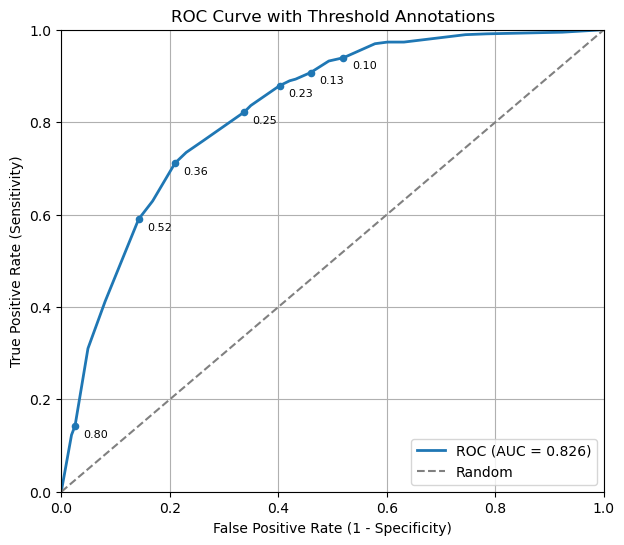

In [2]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, roc_auc_score
# import numpy as np

# y_test, y_pred_prob assumed from your model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

fig, ax = plt.subplots(figsize=(7,6))
ax.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {auc:.3f})')
ax.plot([0, 1], [0, 1], '--', color='gray', label='Random')

# choose ~10 well-spaced points, skipping the first (inf) and the very last
idxs = np.linspace(1, len(thresholds)-2, num=10, dtype=int)

# (optional) focus on thresholds in a sensible range (e.g., 0.1–0.9)
mask = (thresholds[idxs] >= 0.1) & (thresholds[idxs] <= 0.9)
idxs = idxs[mask]

# scatter and annotate
ax.scatter(fpr[idxs], tpr[idxs], s=20, zorder=3)
for i in idxs:
    ax.annotate(f"{thresholds[i]:.2f}",
                (fpr[i], tpr[i]),
                textcoords="offset points",
                xytext=(6, -8),
                fontsize=8)

ax.set_xlabel('False Positive Rate (1 - Specificity)')
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_title('ROC Curve with Threshold Annotations')
ax.legend(loc='lower right')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(True)
plt.savefig('../../fig/churn_roc_curve_with_thresholds.png', dpi=300)
plt.show()



In [3]:
thresholds.shape, y_test.shape

((26,), (2113,))

In [15]:
# Create DataFrame with predictions and actual values
pred_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_prob': y_pred_prob
})

# Sort by predicted probabilities in descending order
pred_df = pred_df.sample(20).sort_values('y_pred_prob', ascending=False)

# Add cumulative sum of actual positive cases
pred_df['cumsum_positives'] = pred_df['y_test'].cumsum()
pred_df['position'] = range(1, len(pred_df) + 1)
pred_df['positive_rate'] = pred_df['cumsum_positives'] / pred_df['position']

# Display the updated dataframe
pred_df

,y_test,y_pred_prob,cumsum_positives,position,positive_rate
2797,1,0.839806,1,1,1.000000
6365,1,0.839806,2,2,1.000000
2708,1,0.795455,3,3,1.000000
5706,1,0.680851,4,4,1.000000
5716,0,0.562232,4,5,0.800000
1446,0,0.562232,4,6,0.666667
2699,0,0.520879,4,7,0.571429
4028,0,0.283951,4,8,0.500000
3762,0,0.226852,4,9,0.444444
1259,1,0.126984,5,10,0.500000


In [19]:
# Genera tabella LaTeX dalle prime 20 righe di pred_df, includendo l'indice originale
latex_df = pred_df[['y_test', 'y_pred_prob', 'positive_rate']].reset_index().rename(columns={'index': 'original_index'})

latex = latex_df.to_latex(index=False,
                          float_format="%.3f",
                          caption='\\tiny Sampled records, with label, predicted probability and positive rate',
)
# Stampa LaTeX e salva su file
print(latex)
with open('pred_df_top20.tex', 'w') as f:
    f.write(latex)

\begin{table}
\caption{\tiny Sampled records, with label, predicted probability and positive rate}
\begin{tabular}{rrrr}
\toprule
original_index & y_test & y_pred_prob & positive_rate \\
\midrule
2797 & 1 & 0.840 & 1.000 \\
6365 & 1 & 0.840 & 1.000 \\
2708 & 1 & 0.795 & 1.000 \\
5706 & 1 & 0.681 & 1.000 \\
5716 & 0 & 0.562 & 0.800 \\
1446 & 0 & 0.562 & 0.667 \\
2699 & 0 & 0.521 & 0.571 \\
4028 & 0 & 0.284 & 0.500 \\
3762 & 0 & 0.227 & 0.444 \\
1259 & 1 & 0.127 & 0.500 \\
2810 & 0 & 0.104 & 0.455 \\
4552 & 0 & 0.091 & 0.417 \\
2525 & 0 & 0.039 & 0.385 \\
4361 & 0 & 0.027 & 0.357 \\
4886 & 0 & 0.027 & 0.333 \\
1116 & 0 & 0.027 & 0.312 \\
839 & 0 & 0.017 & 0.294 \\
5756 & 0 & 0.017 & 0.278 \\
405 & 0 & 0.000 & 0.263 \\
4201 & 0 & 0.000 & 0.250 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
pred_df.sample(20)

,y_test,y_pred_prob
566,0,0.103774
3470,0,0.248555
1154,0,0.017375
4934,0,0.038961
3804,0,0.839806
6945,1,0.103774
6544,1,0.356000
1749,0,0.520879
2150,0,0.520879
6720,0,0.133333
